In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import corner
import arviz as az

from data import GDiff_dataset
from model import load_model
from inference_utils.colored_ps import ColoredPS

import inference_utils.utils as iut
from utils import get_colored_noise_2d, plot_power_spectrum, plot_list_of_images

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Matplotlib settings:
params = {'text.usetex': True,
         'mathtext.default': 'regular',
         'text.latex.preamble': r"""\usepackage{bm}
\usepackage{amsmath}""",
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [41]:
# Target parameters
norm_phi_mode = 'compact' # Normalization mode for phi among ['compact', 'inf', None]
sigma_min, sigma_max = 0.1, 1.5 # Bounds for sigma (no normalization), for HMC
phi_test = -0.4 # Value of varphi: choose between -1 and 1
sigma_test = 0.2 # Noise level: Between sigma_min and sigma_max --> equivalent to 51/255

# Inference parameters
num_chains = 4 # Number of HMC chains
n_it_gibbs = 30 # Number of Gibbs iterations without burn-in
n_it_burnin = 10 # Number of burn-in Gibbs iterations

In [42]:
# Load dataset, diffusion model, and power spectrum model
dataset = GDiff_dataset(dataset="cbsd68")
model = load_model(diffusion_steps=10000, device=device)
#ps_model = ColoredPS(norm_input_phi=norm_phi_mode)

In [43]:
# Make test data

# example_id = 10 # Heron from nano_imagenet
example_id = 12 #np.random.randint(len(dataset))

# Normalize phi and get power spectrum
#phi_test_norm =  iut.normalize_phi(torch.tensor([phi_test]).reshape(-1,1).to(device), mode=norm_phi_mode)
#ps_test = ps_model(phi=phi_test_norm) # power spectrum corresponding to phi_test (taking into account the normalization)

#Get the closest time step (for the DDPM) to the desired noise level
sigma_test_timestep ,sigma_test = model.get_closest_timestep(torch.tensor([sigma_test]), ret_sigma=True)
print(f"Time step corresponding to noise level {sigma_test.item()}: {sigma_test_timestep.item()}")

#Get data and copmpute the alpha_bar_t of the DDPM for the given time step
x = dataset[example_id][0].to(device).unsqueeze(0)
alpha_bar_t = model.alpha_bar_t[sigma_test_timestep.cpu()].reshape(-1, 1, 1, 1).to(device)

# get_colored_noise_2d needs unnormalized parameters
iSNR = torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t)
eps = iSNR * get_colored_noise_2d((1, 3, 256, 256), phi_test).to(device) #epsilon = sigma * N(0, Sigma_\vaphi)
y = x + eps # Noisy image
yt = torch.sqrt(alpha_bar_t) * y # Noisy image normalized for the diffusion model

label_output = f'full_{example_id}'

Time step corresponding to noise level 0.1999870091676712: 579


/tmp/ipykernel_843455/3505178529.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_denoised = model.denoise_samples_batch_time(yt, torch.tensor(sigma_test_timestep).unsqueeze(0), phi_ps=phi_test)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 24.515629547988382
SSIM: 0.6328637
Min/max of Noisy $y$: -0.62/1.63
Min/max of True $x$: 0.10/1.00
Min/max of Denoised $\hat x$: 0.03/1.00
Min/max of Noise $\epsilon$: -0.90/0.85


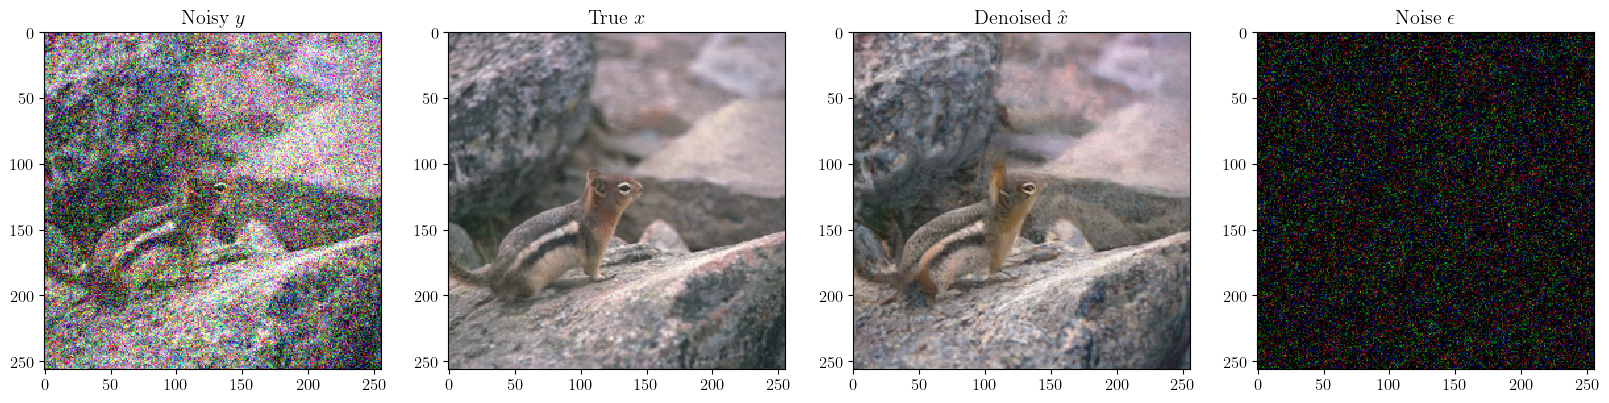

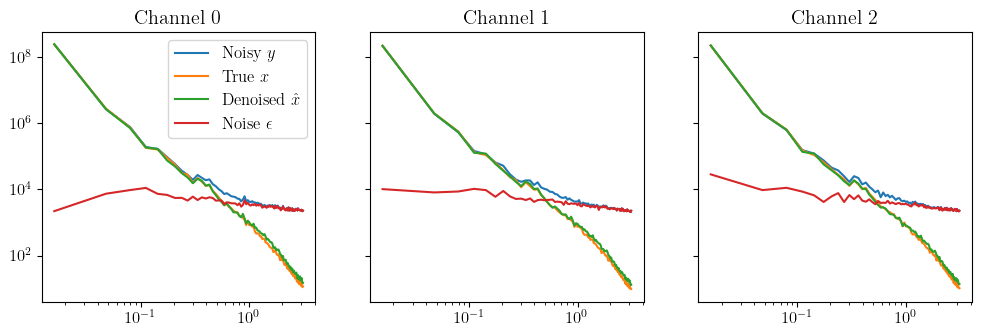

In [45]:
# Sanity check: we denoise the image with the diffusion model given the true parameters (i.e. non-blind setting) and analyze the result

x_denoised = model.denoise_samples_batch_time(yt, torch.tensor(sigma_test_timestep).unsqueeze(0), phi_ps=phi_test)

print("PSNR:", psnr(x[0].cpu().numpy(), x_denoised[0].cpu().numpy(), data_range=1))
print("SSIM:", ssim(x[0].cpu().numpy(), x_denoised[0].cpu().numpy(), channel_axis=0, data_range=1))
data = [y[0], x[0], x_denoised[0], eps[0]]
labels = ["Noisy $y$", "True $x$", "Denoised $\hat x$", "Noise $\epsilon$"]
for i in range(len(data)):
    print(f"Min/max of {labels[i]}: {data[i].min().item():.2f}/{data[i].max().item():.2f}")
plot_list_of_images(data, labels)
plot_power_spectrum(data, labels, figsize=(12, 3.5))

In [49]:
#Blind denoising, return the chains and the denoised samples
#The more chains, the longer it will take to run
phi_all, x_all = model.blind_denoising(y, yt, num_chains_per_sample=num_chains)

Normalized prior bounds are: tensor([0.0000, 0.0400], device='cuda:0') tensor([1.0000, 0.3000], device='cuda:0')


  0%|          | 0/40 [00:00<?, ?it/s]

Adapting step size using 300 iterations
Step size fixed to :  tensor([0.0311, 0.0377, 0.0361, 0.0336], device='cuda:0')


100%|██████████| 40/40 [22:11<00:00, 33.30s/it]


/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


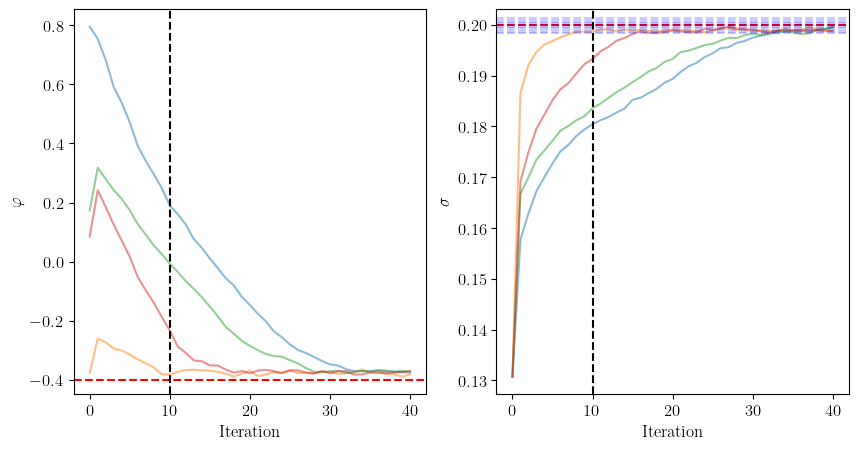

In [50]:
# Plots of the chains for each parameter

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
for i in range(num_chains):
    axs[0].plot(iut.unnormalize_phi(phi_all[i, :, 0], mode=norm_phi_mode).detach().cpu().numpy(), alpha=0.5)
    axs[1].plot(phi_all[i, :, 1].detach().cpu().numpy(), alpha=0.5)
axs[0].set_ylabel(r'$\varphi$')
axs[1].set_ylabel(r'$\sigma$')
axs[0].set_xlabel('Iteration')
axs[1].set_xlabel('Iteration')
axs[0].axhline(phi_test, color='r', linestyle='--')
axs[1].axhline(sigma_test, color='r', linestyle='--')
timesteps_to_plot = torch.arange(sigma_test_timestep.item() - 5, sigma_test_timestep.item() + 5)
sigmas_to_plot = torch.sqrt((1-model.alpha_bar_t[timesteps_to_plot])/model.alpha_bar_t[timesteps_to_plot]).squeeze().cpu().numpy()
for sigma_to_plot in sigmas_to_plot:
    axs[1].axhline(sigma_to_plot, color='b', linestyle='--', alpha=0.2)
axs[0].axvline(n_it_burnin, color='k', linestyle='--')
axs[1].axvline(n_it_burnin, color='k', linestyle='--')
fig.show()

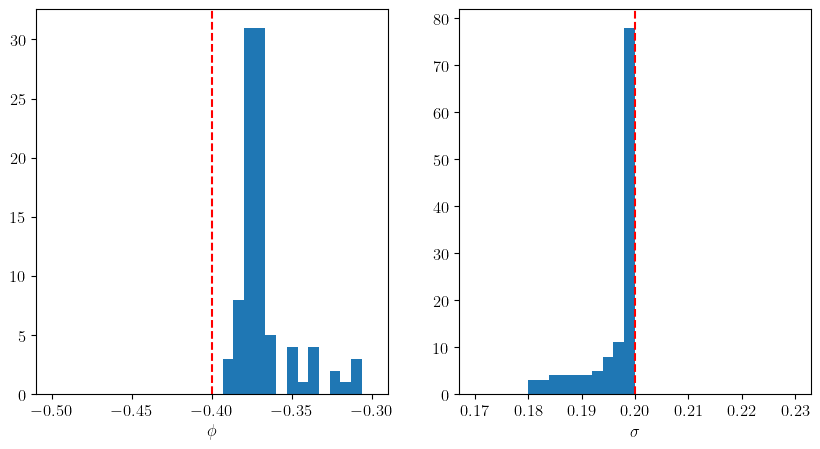

In [51]:
#
# Histograms
#

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(iut.unnormalize_phi(phi_all[:, n_it_burnin:, 0], mode=norm_phi_mode).cpu().numpy().ravel(), bins=30, range=(phi_test - 0.1, phi_test + 0.1))
axs[1].hist(phi_all[:, n_it_burnin:, 1].cpu().numpy().ravel(), bins=30, range=(sigma_test.item() - 0.03, sigma_test.item() + 0.03))
axs[0].set_xlabel(r'$\phi$')
axs[1].set_xlabel(r'$\sigma$')
axs[0].axvline(phi_test, color='r', linestyle='--')
axs[1].axvline(sigma_test, color='r', linestyle='--')
fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR (non-blind): 24.515629547988382
PSNR (blind): 24.55169309563322
SSIM (non-blind): 0.6328637
SSIM (blind): 0.6197445
Min/max of Noisy $\bm{y}$: -0.62/1.63
Min/max of True $\bm{x}$: 0.10/1.00
Min/max of Denoised $\hat{\bm{x}}$ (non-blind): 0.03/1.00
Min/max of Denoised $\hat{\bm{x}}$ (blind): 0.09/1.02
Min/max of Noise $\bm{\epsilon}$: -0.90/0.85


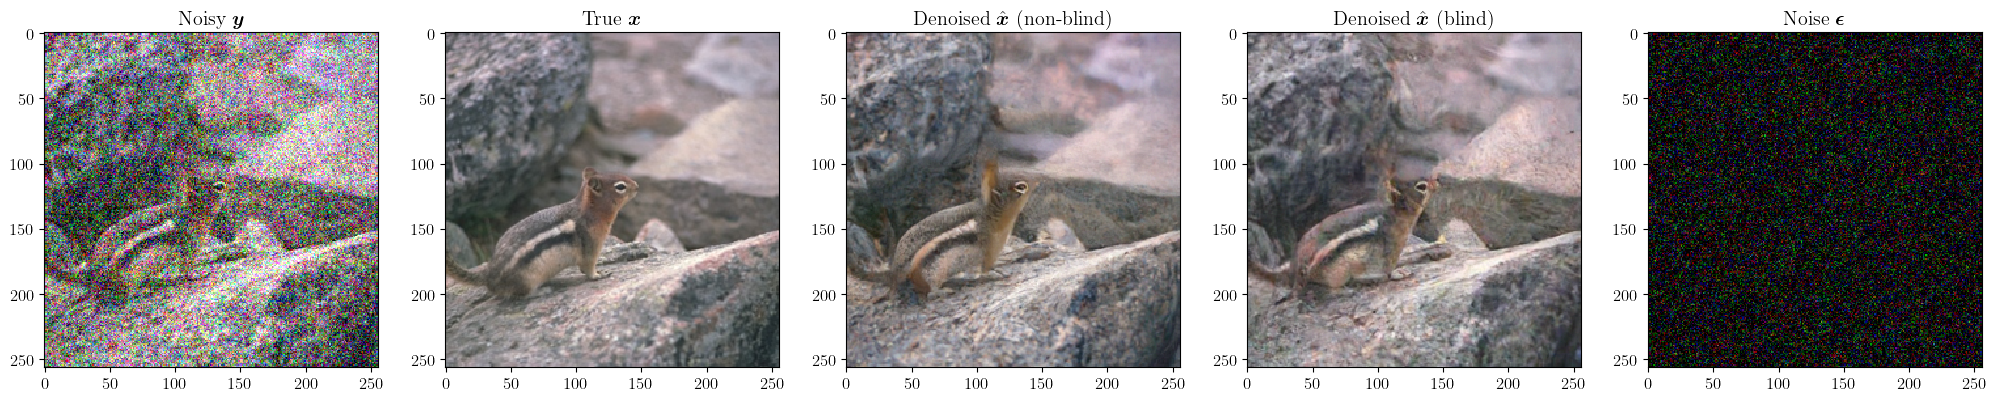

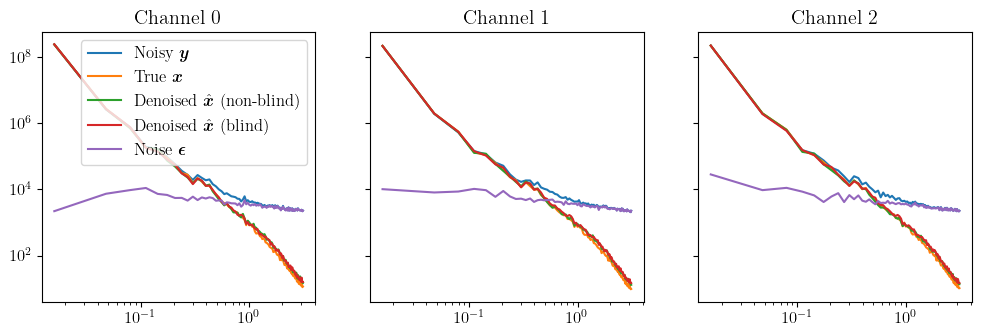

In [52]:
#
# Plot of a reconstruction
#

print("PSNR (non-blind):", psnr(x[0].cpu().numpy(), x_denoised[0].cpu().numpy(), data_range=1))
print("PSNR (blind):", psnr(x[0].cpu().numpy(), x_all[0, -1].cpu().numpy(), data_range=1))
print("SSIM (non-blind):", ssim(x[0].cpu().numpy(), x_denoised[0].cpu().numpy(), channel_axis=0, data_range=1))
print("SSIM (blind):", ssim(x[0].cpu().numpy(), x_all[0, -1].cpu().numpy(), channel_axis=0, data_range=1))
data = [y[0], x[0], x_denoised[0], x_all[0, -1], eps[0]]
labels = [r"Noisy $\bm{y}$", r"True $\bm{x}$", r"Denoised $\hat{\bm{x}}$ (non-blind)", r"Denoised $\hat{\bm{x}}$ (blind)", r"Noise $\bm{\epsilon}$"]
for i in range(len(data)):
    print(f"Min/max of {labels[i]}: {data[i].min().item():.2f}/{data[i].max().item():.2f}")
plot_list_of_images(data, labels)
plot_power_spectrum(data, labels, figsize=(12, 3.5))

In [59]:
phi_est = iut.unnormalize_phi(phi_all[0, -1, 0], mode=norm_phi_mode).item()
sigma_est = phi_all[0, -1, 1].item()
print(f"Estimated phi: {phi_est:.2f}; Real value: {phi_test:.2f}")
print(f"Estimated sigma: {sigma_est:.2f}; Real value: {sigma_test.item():.2f}")

Estimated phi: -0.38; Real value: -0.40
Estimated sigma: 0.20; Real value: 0.20


In [60]:
#Compute the posterior mean, that in theory gives optimal denoising 
x_mean = x_all[:, n_it_burnin:].mean(dim=(0, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


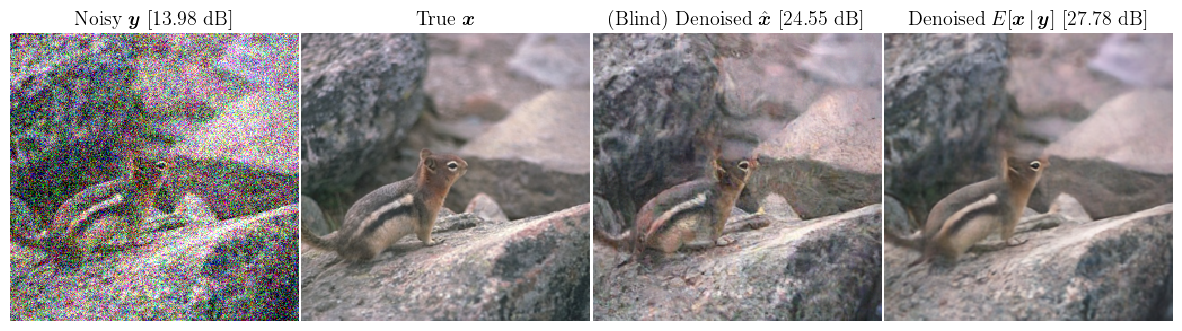

In [61]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)
axs[0].imshow(y[0].cpu().numpy().transpose(1, 2, 0))
axs[0].set_title(r"Noisy $\bm{y}$" + f" [{psnr(x[0].cpu().numpy(), y[0].cpu().numpy(), data_range=1):.2f} dB]")
axs[1].imshow(x[0].cpu().numpy().transpose(1, 2, 0))
axs[1].set_title(r"True $\bm{x}$")
axs[2].imshow(x_all[0, -1].cpu().numpy().transpose(1, 2, 0))
axs[2].set_title(r"(Blind) Denoised $\hat{\bm{x}}$" + f" [{psnr(x[0].cpu().numpy(), x_all[0, -1].cpu().numpy(), data_range=1):.2f} dB]")
axs[3].imshow(x_mean.cpu().numpy().transpose(1, 2, 0))
axs[3].set_title(r"Denoised $E[\bm{x}\,|\,\bm{y}]$" + f" [{psnr(x[0].cpu().numpy(), x_mean.cpu().numpy(), data_range=1):.2f} dB]")
for ax in axs:
    ax.axis('off')
fig.subplots_adjust(wspace=0.01)

In [62]:
## Matplotlib parameters
save_fig = False

if save_fig:
    #check whether output folder exists, otherwise make it:
    import os
    if not os.path.exists("output"):
        os.makedirs("output")
    plt.savefig(f"output/nat_images_denoised_example_{label_output}.pdf", bbox_inches='tight')

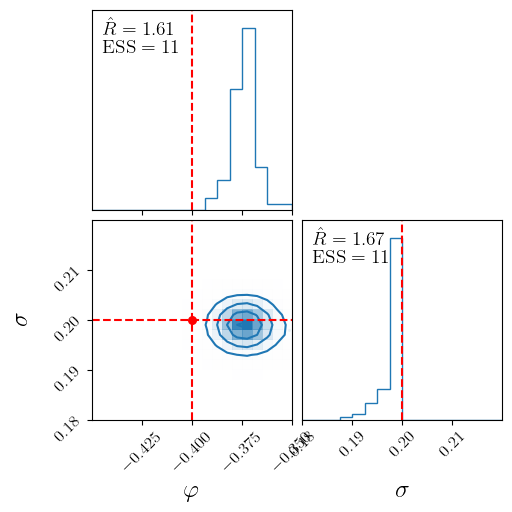

In [63]:
# Corner plot of the inference over \sigma and \varphi

n_it_burning_eff = int(2*n_it_burnin) # Number of samples to remove from the chains

az_infdata = az.convert_to_inference_data(phi_all[:, n_it_burning_eff:, :].cpu().numpy())
ess = az.ess(az_infdata)['x'].values
rhat = az.rhat(az_infdata)['x'].values

tensor_params_all = torch.cat((iut.unnormalize_phi(phi_all[:, n_it_burning_eff:, :1], mode=norm_phi_mode), phi_all[:, n_it_burning_eff:, 1:]), dim=-1).cpu().numpy().reshape(-1, 2)
params_truth = np.array([phi_test, sigma_test.item()])

labels = [r'$\varphi$', r'$\sigma$']

fig = corner.corner(tensor_params_all, labels=labels, show_titles=False, color='C0', hist_kwargs={'color':'C0', 'density':True}, smooth=1.5, hist_bin_factor=0.8, label_kwargs={'fontsize':18}, max_n_ticks=4, range=[(params_truth[0] - 0.05, params_truth[0] + 0.05), (params_truth[1] - 0.02, params_truth[1] + 0.02)])
axes = fig.get_axes()
for i in range(2):
    for j in range(2):
        if i > j:
            axes[i*2+j].axvline(params_truth[j], color='r', linestyle='--')
            axes[i*2+j].axhline(params_truth[i], color='r', linestyle='--')
            axes[i*2+j].scatter(params_truth[j], params_truth[i], color='r', s=30)
        if i == j:
            axes[i*2+j].axvline(params_truth[j], color='r', linestyle='--')
            # Add Rhat and ESS
            axes[i*2+j].text(0.05, 0.95, r'$\hat{{R}} = {:.2f}$'.format(rhat[j]), transform=axes[i*2+j].transAxes, fontsize=14, verticalalignment='top')
            axes[i*2+j].text(0.05, 0.85, r'$\text{{ESS}} = {:.0f}$'.format(ess[j]), transform=axes[i*2+j].transAxes, fontsize=14, verticalalignment='top')
if save_fig:
    fig.savefig(f'output/nat_images_denoised_inference_{label_output}.pdf', bbox_inches='tight')


In [ ]:
#Save the chains for SBC analysis in paper_plots/inference_validation.ipynb
# torch.save(phi_all, os.path.join(output_dir, f'id_{id}_nsamples_{num_samples}_nchains_{num_chains_per_sample}_phi_all_v8.pt'))
# torch.save(phi_true, os.path.join(output_dir, f'id_{id}_nsamples_{num_samples}_nchains_{num_chains_per_sample}_phi_true_v8.pt'))
